---
<h1><B> Deep Learning (AI2100/AI5100)  </h1></B></center>

---

<table>
<tr> 
<td><h3> Assignment : </td>
<td><h3> 4 </td>
</tr>
<tr> 
<td><h3> Name : </td>
<td><h3> Manan Darji </td>
</tr>
<tr> 
<td><h3> Roll Number : </td>
<td> <h3>CS22MTECH14004 </td>
</tr>
<table>

---

## Question

---

1. The adding problem: In this task, each data sample consists of a sequence of variable length, but a constant depth of 2. All values of the first dimension (randomly) lie in [0, 1], and the second dimension being all zeros except for two elements that are marked by 1. Objective of the task is to sum the random values whose second dimensions are marked by 1. Train the different RNNs (Elmon network, LSTM, and GRU) discussed in the class and compare their performance against a baseline that always predicts a sum of 1 plotting the learning curves and final performance. Note that you are expected to implement these models (as opposed to use the builtin constructs).[7 (Elmon)+12 (LSTM)+ 12(GRU)+5(baseline&comparison) = 36] 

2. The following table presents two data samples (x) along with their labels (y). Note that the samples should be of different lengths (n), so the dimensions of each sample can be represented as n × 2. Given examples have lengths of 5 and 8 respectively. You have to generate/create a big dataset (≥ 5000) of such samples for training and testing of the RNNs. [Dataset creation 4 Marks]



<table>
<tr> 
<td> NO </td>
<td> X </td>
<td>  Y  </td>
</tr>
<tr> 
<td> 1 </td>
<td> 
<table>
<tr> <td>0.1</td> <td>0.9 </td> <td>0.25</td> <td> 0.17 </td> <td>0.76</td></tr>
<tr> <td>0 </td> <td>1</td> <td> 0 </td> <td>1 </td> <td>0</td> </tr>
</table>
</td>
<td>  1.07  </td>
<tr> 
<td> 2 </td>
<td> 
<table>
<tr> <td>0.86</td> <td> 0.31 </td> <td> 0.43</td> <td> 0.12 </td> <td> 0.01</td> <td> 0.29</td> <td>0.95</td> <td> 0.09</td> <td>0.52</td> </tr>
<tr> <td>0</td> <td>0</td> <td>1</td> <td>0</td> <td>0</td> <td>0</td> <td>0</td> <td>1</td> <td>0</td> </tr>
</table>
</td>
<td>  0.52  </td>
</tr>
<table>



In [101]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import warnings 
from tqdm import tqdm
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

In [102]:
np.random.seed(8999)
torch.manual_seed(8999)
# Here I have define the simple input arrays 
X,Y = [],[]

# Length of indivisual data point 
LOW_LIM = 2
UPR_LIM = 9

# I have taken the 5000 data points
for _ in range(5000):
  # Randomly select length
  LEN = np.random.randint(LOW_LIM,UPR_LIM)
  # Random points of selected size, value between one and zero
  D1 = np.random.random((LEN)).astype(np.double)
  D2 = np.zeros(LEN)
  # Randomly seet 2 positions as one.
  ONEs = np.random.randint(LEN,size=(2))
  while ONEs[0] == ONEs[1]:
    ONEs = np.random.randint(LEN,size=(2))
  D2[ONEs] = 1
  
  # Append to Data array after coverting to tensor.
  X.append(torch.from_numpy(np.array([(D1[i] , D2[i]) for i in range(LEN)])).double())
  Y.append(torch.from_numpy(np.array([ D1[ONEs[0]] + D1[ONEs[1]] ])))

# Converting to numpy array
X = np.array(X)
Y = np.array(Y)

# Printing the shapes
X.shape,Y.shape

((5000,), (5000,))

In [103]:
# Test Train split of 33 - 66
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [104]:
# Selecting the device
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cpu'

I Have Implemented Following Equation of ElmonRNN

---

Reference : wikipedia

\begin{align}
  &\mathbf{h_t} =  \sigma_h( U_h x_t + W_h h_{t-1} + b_h) \\
  &\mathbf{y_t} =  \sigma_h( V_h h_{t} + b_h)
\end{align}

<center> 

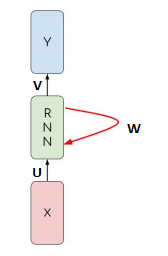

In [105]:
# This is implementation of ElmonRNN 
# I have followed above equations & figure to implement.
class ElmonRNN(nn.Module):
  def __init__(self, INP_S, HID_S, OUT_S):
    super().__init__()

    self.U = nn.Linear(INP_S, HID_S  , bias=False )
    self.W = nn.Linear(HID_S, HID_S)
    self.V = nn.Linear(HID_S, OUT_S)
    
    self.double()

  def forward(self, INP, HID_State):
    Ux = self.U(INP)

    Wh = self.W(HID_State)
    Ht = torch.tanh(Ux + Wh)

    OUT = self.V(Ht)
    return OUT, Ht
        

In [106]:
torch.manual_seed(8999)
# Initializing perameters 
MAX_EPOCH = 25
INP_S  = 2
HID_S  = 10
OUT_S  = 1
L      = 0.005
Model1 = ElmonRNN(INP_S, HID_S, OUT_S).to(device)

print(Model1)

ElmonRNN(
  (U): Linear(in_features=2, out_features=10, bias=False)
  (W): Linear(in_features=10, out_features=10, bias=True)
  (V): Linear(in_features=10, out_features=1, bias=True)
)


In [107]:
# Some Empty dictionary to save data to plot later
TRAIN_LOSS_HIST = {}

# Defined a loss function as MSE
MSE_LOSS = nn.MSELoss()

# Defined OPTIMIZER as Adam
OPTIMIZER = torch.optim.Adam(Model1.parameters(), lr = L)

# Run till MaxEpoch8
for epoch in tqdm(range(MAX_EPOCH)):
  # Empty Temp dicts
  EPOCH_LOSS_HIST = list()
  # Iter over data set [SGD]
  for X_, Y_ in zip(X_train,y_train):
    # Setting gradients to zero
    Model1.zero_grad()
    # Intializing Loss
    loss = 0
    # Intializing perameter to pass in forwardpass 
    HID =  torch.zeros(1, HID_S, requires_grad=False,dtype=torch.float64).to(device)
    X_, Y_ = X_.to(device), Y_.to(device)
    OUT = 0
    # Iter over current Input Sequence
    for i in range(X_.shape[0]):
      OUT, HID = Model1(X_[i,:], HID)
    # finding loss on last output.
    loss = MSE_LOSS(OUT, Y_)
    # Calling Backward on final loss
    loss.backward()
    # Cliping the gradient to prevent exploding gradients
    nn.utils.clip_grad_norm_(Model1.parameters(), 3)
    # Updating model perameters
    OPTIMIZER.step()
    # Saving currunt loss
    EPOCH_LOSS_HIST.append(loss.detach().item())
  # Saving avg loss over whole dataset
  TRAIN_LOSS_HIST[epoch] = torch.tensor(EPOCH_LOSS_HIST).mean()


100%|██████████| 25/25 [02:38<00:00,  6.33s/it]


This is Plot of Loss vs Iteration


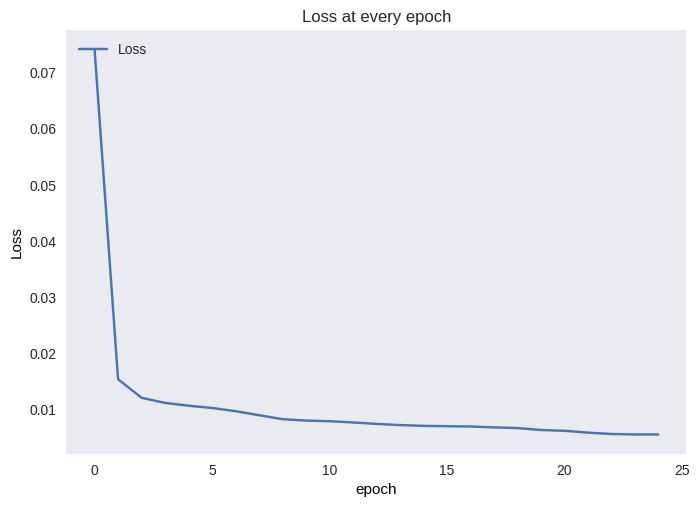

In [108]:
# Plotting Loss over Training.

def PlotLossGraph(X):
  print("This is Plot of Loss vs Iteration")
  axisx = range(len(X.keys()))
  axisy = [0] * (len(X.keys()))
  plt.plot(X.keys(),X.values(), label='Loss')
  plt.title('Loss at every epoch')
  plt.xlabel('epoch', color='#000000')
  plt.ylabel('Loss', color='#000000')
  plt.legend(loc='upper left')
  plt.grid()
  plt.show()

PlotLossGraph(TRAIN_LOSS_HIST)

In [109]:
# Here I have just checked Accuracy of the model
# Since this is regression problem i have taken +-0.02 as perameter to determine correct prediction
torch.manual_seed(8999)
TotalTestPoint = 0
CorrectPred = 0
for X_, Y_ in zip(X_test,y_test):
  X_, Y_ = X_.to(device), Y_.to(device)
  HID, OUT =  torch.zeros(1, HID_S, requires_grad=False,dtype=torch.float64).to(device), 0
  for i in range(X_.shape[0]):
    OUT, HID = Model1(X_[i,:], HID)
  if abs(OUT.item()-Y_.item()) <0.02:
    CorrectPred+=1
  TotalTestPoint+=1

ElmonRNN_ACC = CorrectPred/TotalTestPoint 
print("Accuracy : %2.4f"%ElmonRNN_ACC )

Accuracy : 0.1945 %


I Have Implemented Following Equation for LSTM

---

Reference : wikipedia

\begin{align}
  &\mathbf{f_t} =  \sigma_g( U_f x_t + W_f c_{t-1} + b_f) \\
  &\mathbf{i_t} =  \sigma_g( U_i x_t + W_i c_{t-1} + b_i) \\
  &\mathbf{o_t} =  \sigma_g( U_o x_t + W_o c_{t-1} + b_o) \\
  &\mathbf{c_t} =   f_t \odot c_{t-1} + i_t \odot \sigma_c( U_c x_t + b_c) \\
  &\mathbf{h_t} =   o_t \odot  \sigma_h(c_{t})
\end{align}




<center>

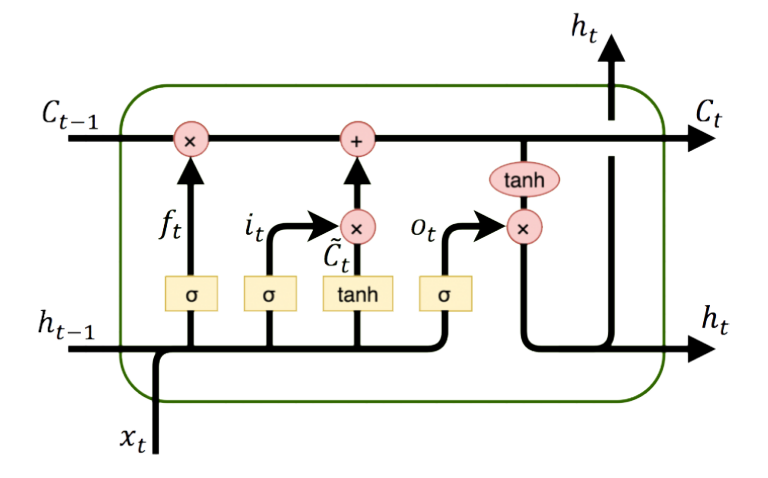

In [110]:
# This is implementation of LSTM 
# I have followed above equations & figure to implement.
class LSTM(nn.Module):
    def __init__(self, INP_S, HID_S, OUT_S):
        super().__init__()

        self.Ui = nn.Linear(INP_S, HID_S  , bias=False )
        self.Wi = nn.Linear(HID_S, HID_S)

        self.Uo = nn.Linear(INP_S, HID_S  , bias=False )
        self.Wo = nn.Linear(HID_S, HID_S)

        self.Uf = nn.Linear(INP_S, HID_S  , bias=False )
        self.Wf = nn.Linear(HID_S, HID_S)

        self.Uc = nn.Linear(INP_S, HID_S)
        self.Wc = nn.Linear(HID_S, HID_S)

        self.V = nn.Linear(HID_S, OUT_S)

        self.double()
    
    def forward(self, INP, HID_State, CELL_State):
        INPuf = self.Uf(INP)
        INPwf = self.Wf(HID_State)
        Ft = torch.sigmoid(INPuf + INPwf)
   
        INPui = self.Ui(INP)
        INPwi = self.Wi(HID_State)
        It = torch.sigmoid(INPui + INPwi)

        INPuo = self.Uo(INP)
        INPwo = self.Wo(HID_State)
        Ot = torch.sigmoid(INPuo + INPwo)     

        INPuc = self.Uc(INP)
        CTt = torch.sigmoid(INPuc)

        Ct = (Ft * CELL_State) + ( It * CTt)

        Ht = Ot * torch.sigmoid(Ct)

        OUT = self.V(Ht)
        return OUT, Ht, Ct

In [111]:
torch.manual_seed(8999)
# Initializing perameters 
MAX_EPOCH = 25
INP_S  = 2
HID_S  = 10
OUT_S  = 1
L      = 0.005
Model2 = LSTM(INP_S, HID_S, OUT_S).to(device)

print(Model2)

LSTM(
  (Ui): Linear(in_features=2, out_features=10, bias=False)
  (Wi): Linear(in_features=10, out_features=10, bias=True)
  (Uo): Linear(in_features=2, out_features=10, bias=False)
  (Wo): Linear(in_features=10, out_features=10, bias=True)
  (Uf): Linear(in_features=2, out_features=10, bias=False)
  (Wf): Linear(in_features=10, out_features=10, bias=True)
  (Uc): Linear(in_features=2, out_features=10, bias=True)
  (Wc): Linear(in_features=10, out_features=10, bias=True)
  (V): Linear(in_features=10, out_features=1, bias=True)
)


In [112]:
# Some Empty dictionary to save data to plot later
TRAIN_LOSS_HIST_LSTM = {}

# Defined a loss function as MSE
MSE_LOSS = nn.MSELoss()

# Defined OPTIMIZER as Adam
OPTIMIZER = torch.optim.Adam(Model2.parameters(), lr = L)

# Run till MaxEpoch8
for epoch in tqdm(range(MAX_EPOCH)):
  # Empty Temp dicts
  EPOCH_LOSS_HIST_LSTM = list()
  # Iter over data set [SGD]
  for X_, Y_ in zip(X_train,y_train):
    # Setting gradients to zero
    Model2.zero_grad()
    # Intializing Loss
    loss = 0
    # Intializing perameter to pass in forwardpass 
    HID =  torch.zeros(1, HID_S, requires_grad=False,dtype=torch.float64).to(device)
    CELL =  torch.zeros(1, HID_S, requires_grad=False,dtype=torch.float64).to(device)
    X_, Y_ = X_.to(device), Y_.to(device)
    for i in range(X_.shape[0]):
      OUT, HID, CELL = Model2(X_[i,:], HID,CELL)
    # finding loss on last output.
    loss = MSE_LOSS(OUT, Y_)
    # Calling Backward on final loss
    loss.backward()
    # Cliping the gradient to prevent exploding gradients
    nn.utils.clip_grad_norm_(Model2.parameters(), 3)
    # Updating model perameters
    OPTIMIZER.step()
    # Saving currunt loss
    EPOCH_LOSS_HIST_LSTM.append(loss.detach().item())
  # Saving avg loss over whole dataset
  TRAIN_LOSS_HIST_LSTM[epoch] = torch.tensor(EPOCH_LOSS_HIST_LSTM).mean()


100%|██████████| 25/25 [07:06<00:00, 17.06s/it]


This is Plot of Loss vs Iteration


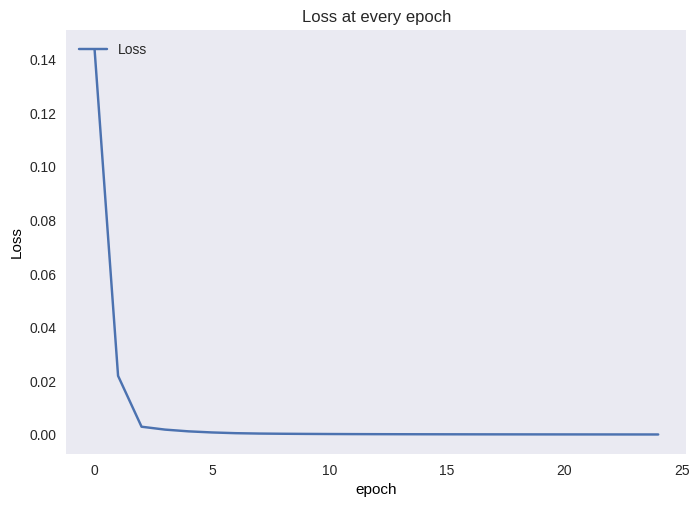

In [113]:
PlotLossGraph(TRAIN_LOSS_HIST_LSTM)

In [114]:
# Here I have just checked Accuracy of the model
# Since this is regression problem i have taken +-0.02 as perameter to determine correct prediction
TotalTestPoint = 0
CorrectPred = 0
for X_, Y_ in zip(X_test,y_test):
  X_, Y_ = X_.to(device), Y_.to(device)
  HID, OUT =  torch.zeros(1, HID_S, requires_grad=False,dtype=torch.float64).to(device), 0
  CELL =  torch.zeros(1, HID_S, requires_grad=False,dtype=torch.float64).to(device)
  for i in range(X_.shape[0]):
    OUT, HID, CELL = Model2(X_[i,:], HID,CELL)
  if abs(OUT.item()-Y_.item()) <0.02:
    CorrectPred+=1
  TotalTestPoint+=1
LSTM_ACC = CorrectPred/TotalTestPoint
print("Accuracy :  %2.4f"%LSTM_ACC )

Accuracy :  0.9867 %


I Have Implemented Following Equation of GRU

---

Reference : wikipedia, Sir PPTs

\begin{align}
  &\mathbf{z_t} =  \sigma_g( U_z x_t + W_z c_{t-1} + b_z) \\
  &\mathbf{r_t} =  \sigma_g( U_r x_t + W_r c_{t-1} + b_r) \\
  &\mathbf{\hat{h}_t} =  \emptyset_g( U_h x_t + W_h ( r_t \odot h_{t-1})) \\
  &\mathbf{h_t} =   ( 1 - z_t ) \odot  h_{t-1} + z_t \odot \hat{h}_t
\end{align}


<center>

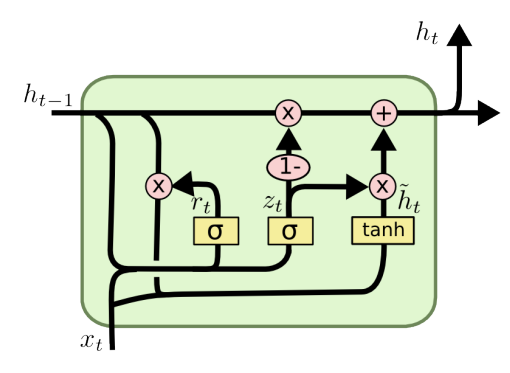

In [115]:
# This is implementation of GRU
# I have followed above equations & figure to implement.
class GRU(nn.Module):
    def __init__(self, INP_S, HID_S, OUT_S):
        super().__init__()
        
        self.Uz = nn.Linear(INP_S, HID_S  , bias=False )
        self.Wz = nn.Linear(HID_S, HID_S)

        self.Ur = nn.Linear(INP_S, HID_S  , bias=False )
        self.Wr = nn.Linear(HID_S, HID_S)

        self.Uh = nn.Linear(INP_S, HID_S  , bias=False)
        self.Wh = nn.Linear(HID_S, HID_S , bias=False )

        self.V = nn.Linear(HID_S, OUT_S)

        self.double()
    
    def forward(self, INP, HID_State):
        INPuz = self.Uz(INP)
        HIDwz = self.Wz(HID_State)
        Zt = torch.sigmoid(INPuz + HIDwz)
   
        INPur = self.Ur(INP)
        HIDwr = self.Wr(HID_State)
        Rt = torch.sigmoid(INPur + HIDwr)

        INPuh = self.Uh(INP)
        HIDwh = self.Wh(Rt * HID_State)
        Ht_hat = torch.tanh(INPuh + HIDwh)  

        Ht = ((1 - Zt) * HID_State) + (Zt * Ht_hat)

        OUT = self.V(Ht)
        return OUT, Ht

In [116]:
torch.manual_seed(8999)
# Initializing perameters 
MAX_EPOCH = 25
INP_S = 2
HID_S = 10
OUT_S = 1
L     = 0.005
Model3 = GRU(INP_S, HID_S, OUT_S).to(device)

print(Model3)

GRU(
  (Uz): Linear(in_features=2, out_features=10, bias=False)
  (Wz): Linear(in_features=10, out_features=10, bias=True)
  (Ur): Linear(in_features=2, out_features=10, bias=False)
  (Wr): Linear(in_features=10, out_features=10, bias=True)
  (Uh): Linear(in_features=2, out_features=10, bias=False)
  (Wh): Linear(in_features=10, out_features=10, bias=False)
  (V): Linear(in_features=10, out_features=1, bias=True)
)


In [117]:
# Some Empty dictionary to save data to plot later
TRAIN_LOSS_HIST_GRU = {}

# Defined a loss function as MSE
MSE_LOSS = nn.MSELoss()

# Defined OPTIMIZER as Adam
OPTIMIZER = torch.optim.Adam(Model3.parameters(), lr = L)

# Run till MaxEpoch8
for epoch in tqdm(range(MAX_EPOCH)):
  # Empty Temp dicts
  EPOCH_LOSS_HIST_GRU = list()

  # Iter over data set [SGD]
  for X_, Y_ in zip(X_train,y_train):
    # Setting gradients to zero
    Model3.zero_grad()
    # Intializing Loss
    loss = 0
    # Intializing perameter to pass in forwardpass 
    HID =  torch.zeros(1, HID_S, requires_grad=False,dtype=torch.float64).to(device)
    X_, Y_ = X_.to(device), Y_.to(device)
    for i in range(X_.shape[0]):
      OUT, HID = Model3(X_[i,:], HID)
    # finding loss on last output.
    loss  = MSE_LOSS(OUT, Y_)

    # Calling Backward on final loss
    loss.backward()
    # Cliping the gradient to prevent exploding gradients
    nn.utils.clip_grad_norm_(Model3.parameters(), 3)
    # Updating model perameters
    OPTIMIZER.step()
    # Saving currunt loss
    EPOCH_LOSS_HIST_GRU.append(loss.detach().item())
  # Saving avg loss over whole dataset
  TRAIN_LOSS_HIST_GRU[epoch] = torch.tensor(EPOCH_LOSS_HIST_GRU).mean()


100%|██████████| 25/25 [06:12<00:00, 14.89s/it]


This is Plot of Loss vs Iteration


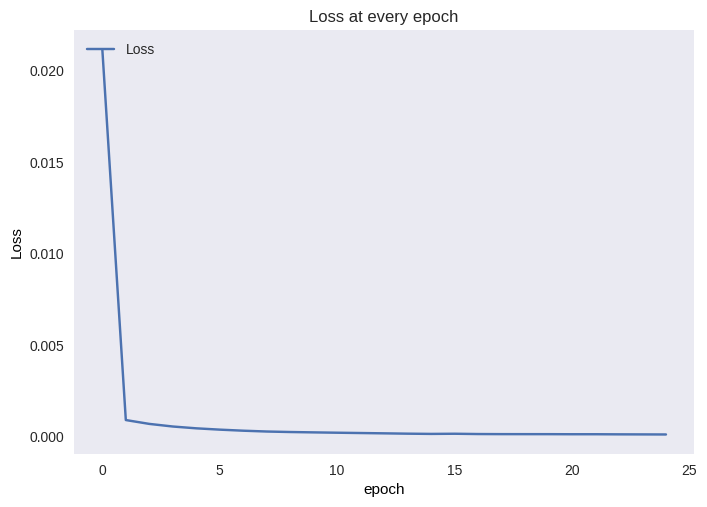

In [118]:
PlotLossGraph(TRAIN_LOSS_HIST_GRU)

In [119]:
# Here I have just checked Accuracy of the model
# Since this is regression problem i have taken +-0.02 as perameter to determine correct prediction
TotalTestPoint = 0
CorrectPred = 0
for X_, Y_ in zip(X_test,y_test):
  X_, Y_ = X_.to(device), Y_.to(device)
  HID, OUT =  torch.zeros(1, HID_S, requires_grad=False,dtype=torch.float64).to(device), 0
  for i in range(X_.shape[0]):
    OUT, HID = Model3(X_[i,:], HID)
  if abs(OUT.item()-Y_.item()) <0.02:
    CorrectPred+=1
  TotalTestPoint+=1
GRU_ACC = CorrectPred/TotalTestPoint
print("Accuracy :  %2.4f"%GRU_ACC )

Accuracy :  0.9927 %


In [120]:
# Calculating Baseline
TRAIN_LOSS_HIST_BASELINE = {}
for epoch in tqdm(range(MAX_EPOCH)): 
  EPOCH_LOSS_HIST_BASELINE = list() 
  for X_, Y_ in zip(X_train,y_train):
    lossB = MSE_LOSS(torch.tensor(1).to(device), Y_)
    EPOCH_LOSS_HIST_BASELINE.append(lossB.detach().item())
  TRAIN_LOSS_HIST_BASELINE[epoch] = torch.tensor(EPOCH_LOSS_HIST_BASELINE).mean()

100%|██████████| 25/25 [00:05<00:00,  4.69it/s]


### Some Inferences

----

* So here i have plotted all models training losses with baseline.
* and we can see that here ElmonRNN < LSTM < GRU
  * For smaller data set GRU will perform batter then LSTM.
* we can also see that all models loss is less then baseline

This is Plot of Loss vs Iteration


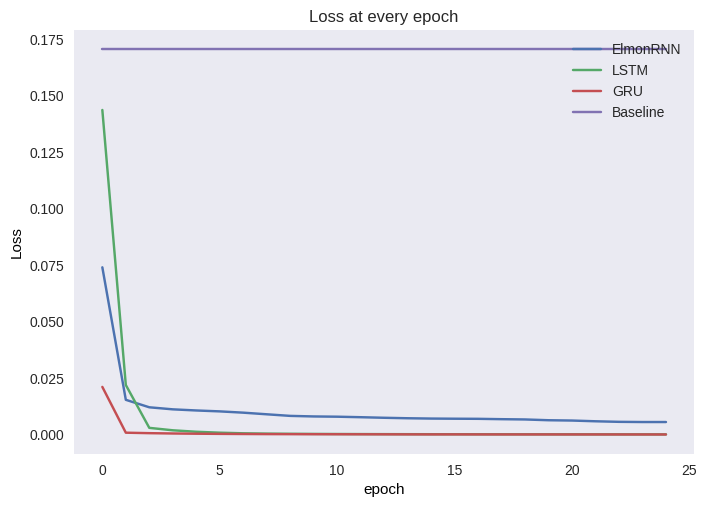

In [121]:
  print("This is Plot of Loss vs Iteration")
  axisx = range(len(TRAIN_LOSS_HIST_LSTM.keys()))
  axisy = [0] * (len(TRAIN_LOSS_HIST_LSTM.keys()))
  plt.plot(TRAIN_LOSS_HIST.keys(),TRAIN_LOSS_HIST.values(),  label='ElmonRNN')
  plt.plot(TRAIN_LOSS_HIST_LSTM.keys(),TRAIN_LOSS_HIST_LSTM.values(), label='LSTM')
  plt.plot(TRAIN_LOSS_HIST_GRU.keys(),TRAIN_LOSS_HIST_GRU.values(), label='GRU')
  plt.plot(TRAIN_LOSS_HIST_BASELINE.keys(),TRAIN_LOSS_HIST_BASELINE.values(), label='Baseline')
  plt.title('Loss at every epoch')
  plt.xlabel('epoch', color='#000000')
  plt.ylabel('Loss', color='#000000')
  plt.legend(loc='upper right')
  plt.grid()
  plt.show()

In [122]:
print("Accuracys of Models")
print("-"*29)
print("| ElmonRNN_ACC".ljust(15), ("|  %2.2f "%(ElmonRNN_ACC*100)+"%  |").rjust(7,'0'))
print("| LSTM_ACC".ljust(15),     ("|  %2.2f "%(LSTM_ACC*100)+"%  |").rjust(7,'0'))
print("| GRU_ACC".ljust(15),      ("|  %2.2f "%(GRU_ACC*100)+"%  |").rjust(7,'0'))
print("-"*29)

Accuracys of Models
-----------------------------
| ElmonRNN_ACC  |  19.45 %  |
| LSTM_ACC      |  98.67 %  |
| GRU_ACC       |  99.27 %  |
-----------------------------



* Sir Mentioned this in the Google Classroom comments:
  * (you may introduce some test samples  beyond 9 for evaluating the model)
  * So I Have Tested this.
  * we can see perfomance :  ElmonRNN < LSTM < GRU
  * as size gets bigger models perform worst

In [129]:
np.random.seed(8999)
torch.manual_seed(8999)

Test_Sample_Sizes = [15,20,25,30] 
print("_"*100)
for S in Test_Sample_Sizes:
  D1 = np.random.random(S).astype(np.double)
  D2 = np.zeros(S)
  # Randomly seet 2 positions as one.
  ONEs = np.random.randint(S,size=(2))
  while ONEs[0] == ONEs[1]:
    ONEs = np.random.randint(S,size=(2))
  D2[ONEs] = 1
  
  # Append to Data array after coverting to tensor.
  X_Test = torch.from_numpy(np.array([(D1[i] , D2[i]) for i in range(S)])).double()
  Y_Test = torch.from_numpy(np.array([ D1[ONEs[0]] + D1[ONEs[1]] ]))

  print("For Input Length :",S)
  print("_"*50)
  print("ElmonRNN :".ljust(15) , end = '')
  HID, OUT =  torch.zeros(1, HID_S, requires_grad=False,dtype=torch.float64).to(device), 0
  for i in range(X_Test.shape[0]):
    OUT, HID = Model1(X_Test[i,:], HID)
  print("| Y : %1.4f "%Y_Test.item()," | Pred : %1.4f  |"%OUT.item())

  print("LSTM :".ljust(15) , end = '')
  HID, OUT =  torch.zeros(1, HID_S, requires_grad=False,dtype=torch.float64).to(device), 0
  CELL =  torch.zeros(1, HID_S, requires_grad=False,dtype=torch.float64).to(device)
  for i in range(X_Test.shape[0]):
    OUT, HID, CELL = Model2(X_Test[i,:], HID,CELL)
  print("| Y : %1.4f "%Y_Test.item()," | Pred : %1.4f  |"%OUT.item())

  print("GRU :".ljust(15) , end = '')
  HID, OUT =  torch.zeros(1, HID_S, requires_grad=False,dtype=torch.float64).to(device), 0
  for i in range(X_Test.shape[0]):
    OUT, HID = Model3(X_Test[i,:], HID)
  print("| Y : %1.4f "%Y_Test.item()," | Pred : %1.4f  |"%OUT.item())

  print("_"*100)

____________________________________________________________________________________________________
For Input Length : 15
__________________________________________________
ElmonRNN :     | Y : 1.8296   | Pred : 1.5730  |
LSTM :         | Y : 1.8296   | Pred : 1.8205  |
GRU :          | Y : 1.8296   | Pred : 1.8262  |
____________________________________________________________________________________________________
For Input Length : 20
__________________________________________________
ElmonRNN :     | Y : 1.6875   | Pred : 1.3319  |
LSTM :         | Y : 1.6875   | Pred : 1.6810  |
GRU :          | Y : 1.6875   | Pred : 1.6852  |
____________________________________________________________________________________________________
For Input Length : 25
__________________________________________________
ElmonRNN :     | Y : 1.2127   | Pred : 0.9639  |
LSTM :         | Y : 1.2127   | Pred : 1.2322  |
GRU :          | Y : 1.2127   | Pred : 1.1761  |
_____________________________________

# End
* Note: Please do Run All only because there might be overlapping variable which can show error or incorrect output.
---

<center><h1> Thank You!